EJERCICIO 2 PROYECTO INVESTIGACIÓN

Importamos las librerías necesarias:

In [21]:
#importaciones para preprocesado:
import os
from PIL import Image
import numpy as np

#importaciones para poner etiquetas:
import csv

#importaciones para crear modelo:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

#importaciones para los k-folds:
from sklearn.model_selection import StratifiedKFold


Seleccionamos los directorios de las imágenes:

In [22]:
# Definimos las rutas de las diferentes carpetas
base_path = "objects"
images_path = os.path.join(base_path, "images")
masks_path = os.path.join(base_path, "masks")
output_path = os.path.join(base_path, "output")

os.makedirs(output_path, exist_ok=True)


Aplicamos las máscaras a las imágenes:

In [23]:

# Recorremos las carpetas de imágenes
for animal in os.listdir(images_path):
    animal_images_path = os.path.join(images_path, animal)
    animal_masks_path = os.path.join(masks_path, animal)
    animal_output_path = os.path.join(output_path, animal)

    if not os.path.isdir(animal_images_path) or not os.path.isdir(animal_masks_path):
        print(f"Carpeta faltante para {animal}, omitiendo...")
        continue

    os.makedirs(animal_output_path, exist_ok=True)

    # Recorremos las imágenes buscando la máscara correspondiente
    for image_name in sorted(os.listdir(animal_images_path)):
    
        if not image_name.startswith("image_") or not image_name.endswith(".jpg"):
            print(f"Archivo ignorado: {image_name}")
            continue

        image_number = image_name.split("_")[1].split(".")[0]  # Extrae el número de imagen
        mask_name = f"mask_{image_number}.png"
        image_path = os.path.join(animal_images_path, image_name)
        mask_path = os.path.join(animal_masks_path, mask_name)

        # Verifica que existan tanto la imagen como la máscara
        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"Faltan archivos para {image_name} y {mask_name}, omitiendo...")
            continue

        try:
            image = Image.open(image_path).convert("RGBA")  
            mask = Image.open(mask_path).convert("L")

            mask = mask.resize(image.size)

            image_array = np.array(image)
            mask_array = np.array(mask)

            # Aplicamos la máscara a la imagen
            image_array[mask_array == 0] = [0, 0, 0, 0] 

            combined_image = Image.fromarray(image_array, "RGBA")
            rgb_image = combined_image.convert("RGB")

            # Guardamos la imagen resultante en formato JPEG
            output_image_path = os.path.join(animal_output_path, image_name)
            output_image_path = output_image_path.replace(".jpg", "_combined.jpg")
            rgb_image.save(output_image_path, "JPEG")

            print(f"Procesado y guardado: {output_image_path}")
        except Exception as e:
            print(f"Error al procesar {image_name}: {e}")

print("Proceso completado.")


Procesado y guardado: objects\output\elephant\image_0001_combined.jpg
Procesado y guardado: objects\output\elephant\image_0002_combined.jpg
Procesado y guardado: objects\output\elephant\image_0003_combined.jpg
Procesado y guardado: objects\output\elephant\image_0004_combined.jpg
Procesado y guardado: objects\output\elephant\image_0005_combined.jpg
Procesado y guardado: objects\output\elephant\image_0006_combined.jpg
Procesado y guardado: objects\output\elephant\image_0007_combined.jpg
Procesado y guardado: objects\output\elephant\image_0008_combined.jpg
Procesado y guardado: objects\output\elephant\image_0009_combined.jpg
Procesado y guardado: objects\output\elephant\image_0010_combined.jpg
Procesado y guardado: objects\output\elephant\image_0011_combined.jpg
Procesado y guardado: objects\output\elephant\image_0012_combined.jpg
Procesado y guardado: objects\output\elephant\image_0013_combined.jpg
Procesado y guardado: objects\output\elephant\image_0014_combined.jpg
Procesado y guardado

Etiquetamos las imágenes según su carpeta:

In [24]:
main_folder = "objects/output"
output_csv = "image_labels.csv"

with open(output_csv, mode='w', newline='') as csvfile:

    writer = csv.writer(csvfile)
    writer.writerow(["image_path", "label"])
    
    # Recorremos las carpetas de animales
    for folder in os.listdir(main_folder):
        folder_path = os.path.join(main_folder, folder)
        
        if os.path.isdir(folder_path):
            # Usamos el nombre de la carpeta como etiqueta
            label = folder
            
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                
                writer.writerow([image_path, label])

print(f"Etiquetas generadas en {output_csv}")


Etiquetas generadas en image_labels.csv


Creamos una función para aplicar el downsampling:

In [36]:
def apply_downsampling(images, target_black_pixels, image_size):
    adjusted_images = []
    
    for img in images:
        # Detectar el área del animal (bounding box)
        non_black_pixels = np.argwhere(img > 0)  # Píxeles no negros
        top, left = non_black_pixels.min(axis=0)  # Coordenadas mínimas
        bottom, right = non_black_pixels.max(axis=0)  # Coordenadas máximas

        # Bounding box que contiene el animal
        animal_bbox = img[top:bottom+1, left:right+1]

        # Calcular píxeles negros fuera del bounding box
        current_black_pixels = np.sum(img == 0)
        black_pixels_to_remove = current_black_pixels - target_black_pixels

        # Recortar píxeles negros uniformemente de los bordes
        if black_pixels_to_remove > 0:
            # Calcular recorte de cada borde (sin tocar el bounding box)
            top_crop = min(top, black_pixels_to_remove // 4)
            bottom_crop = min(img.shape[0] - bottom - 1, black_pixels_to_remove // 4)
            left_crop = min(left, black_pixels_to_remove // 4)
            right_crop = min(img.shape[1] - right - 1, black_pixels_to_remove // 4)
            
            # Aplicar el recorte
            img = img[top - top_crop : bottom + 1 + bottom_crop, 
                      left - left_crop : right + 1 + right_crop]

        # Redimensionar al tamaño deseado
        img = Image.fromarray(img)
        img = img.resize(image_size)  # Redimensiona al tamaño especificado
        adjusted_images.append(np.array(img))
    
    return adjusted_images


Cargamos las etiquetas en nuestro modelo:

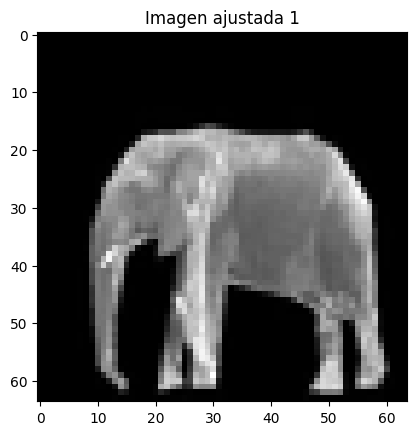

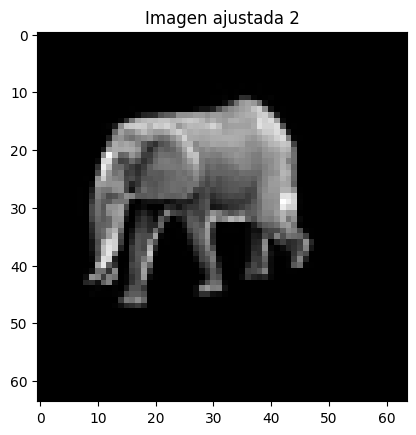

In [37]:
csv_file = "image_labels.csv"

image_size = (64, 64)

features = []
labels = []
# cargamos las imágenes y etiquetas del csv
processed_images = []
with open(csv_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        image_path = row["image_path"]
        label = row["label"]
        
        try:
            with Image.open(image_path) as img:
                img = img.resize(image_size).convert("L")
                img_array = np.array(img)  
                processed_images.append(img_array)
                labels.append(label)
        except Exception as e:
            print(f"Error al procesar {image_path}: {e}")

# Calcula el menor número de píxeles negros en las imágenes
min_black_pixels = min(np.sum(img == 0) for img in processed_images)

processed_images = apply_downsampling(processed_images, target_black_pixels=min_black_pixels, image_size=image_size)

features = [img.flatten() for img in processed_images]

# Convertimos las listas a array de NumPy
features = np.array(features)
labels = np.array(labels)


import matplotlib.pyplot as plt
#PARA VER SI EL DOWNSAMPLING VA BIEN.
for i in range(2):  
    plt.imshow(processed_images[i], cmap="gray")
    plt.title(f"Imagen ajustada {i+1}")
    plt.show()



Entrenamiento con k-folds:

In [27]:

# Función para calcular DICE
def dice_score(y_true, y_pred):
    le = LabelEncoder()
    y_true_encoded = le.fit_transform(y_true)
    y_pred_encoded = le.transform(y_pred)
    
    # Calculamos la intersección y la unión de las predicciones y etiquetas verdaderas
    intersection = np.sum(y_true_encoded == y_pred_encoded)  # Píxeles correctos (positivos y negativos)
    union = np.sum(y_true_encoded) + np.sum(y_pred_encoded)  # Total de píxeles verdaderos y predichos como positivos
    
    # Calculamos DICE usando la fórmula
    dice = (2. * intersection) / (union + intersection)
    return dice

# Configuración de StratifiedKFold
k = 15
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []  
fold_f1_scores = []   
fold_precisions = []  
fold_recalls = []     
fold_dice_scores = [] 

for fold, (train_idx, test_idx) in enumerate(skf.split(features, labels)):
    print(f"\nFold {fold + 1}/{k}")
    
    # División de los datos en entrenamiento y test para este fold
    X_train, X_test = features[train_idx], features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    # Entrenamiento del modelo Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Predicciones en el conjunto de test
    y_pred = rf_model.predict(X_test)
    
    # Calculamos las métricas y las guardamos
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' para balancear las clases
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    dice = dice_score(y_test, y_pred)  # Calculamos DICE
    
    fold_accuracies.append(accuracy)
    fold_f1_scores.append(f1)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_dice_scores.append(dice)
    
    print(f"Precisión en Fold {fold + 1}: {accuracy:.4f}")
    print(f"F1 Score en Fold {fold + 1}: {f1:.4f}")
    print(f"Precisión en Fold {fold + 1}: {precision:.4f}")
    print(f"Recall en Fold {fold + 1}: {recall:.4f}")
    print(f"DICE Score en Fold {fold + 1}: {dice:.4f}")

# Resultados finales
print("\nResultados de k-Fold Cross-Validation:")
print("------------------------------------------------------------------")

print(f"Precisión promedio: {np.mean(fold_accuracies):.4f}")
print(f"Desviación estándar de la precisión: {np.std(fold_accuracies):.4f}")
print("------------------------------------------------------------------")

print(f"F1 Score promedio: {np.mean(fold_f1_scores):.4f}")
print(f"Desviación estándar del F1 Score: {np.std(fold_f1_scores):.4f}")
print("------------------------------------------------------------------")

print(f"Precisión promedio: {np.mean(fold_precisions):.4f}")
print(f"Desviación estándar de la precisión: {np.std(fold_precisions):.4f}")
print("------------------------------------------------------------------")

print(f"Recall promedio: {np.mean(fold_recalls):.4f}")
print(f"Desviación estándar del recall: {np.std(fold_recalls):.4f}")
print("------------------------------------------------------------------")

print(f"DICE Score promedio: {np.mean(fold_dice_scores):.4f}")
print(f"Desviación estándar de DICE: {np.std(fold_dice_scores):.4f}")
print("------------------------------------------------------------------")





Fold 1/15
Precisión en Fold 1: 0.7647
F1 Score en Fold 1: 0.7497
Precisión en Fold 1: 0.7451
Recall en Fold 1: 0.7647
DICE Score en Fold 1: 0.4062

Fold 2/15
Precisión en Fold 2: 0.5294
F1 Score en Fold 2: 0.5523
Precisión en Fold 2: 0.6176
Recall en Fold 2: 0.5294
DICE Score en Fold 2: 0.2903

Fold 3/15
Precisión en Fold 3: 0.7647
F1 Score en Fold 3: 0.7432
Precisión en Fold 3: 0.7422
Recall en Fold 3: 0.7647
DICE Score en Fold 3: 0.4127

Fold 4/15
Precisión en Fold 4: 0.5625
F1 Score en Fold 4: 0.5875
Precisión en Fold 4: 0.6250
Recall en Fold 4: 0.5625
DICE Score en Fold 4: 0.3529

Fold 5/15
Precisión en Fold 5: 0.8125
F1 Score en Fold 5: 0.8115
Precisión en Fold 5: 0.8250
Recall en Fold 5: 0.8125
DICE Score en Fold 5: 0.4127

Fold 6/15
Precisión en Fold 6: 0.6250
F1 Score en Fold 6: 0.6190
Precisión en Fold 6: 0.6333
Recall en Fold 6: 0.6250
DICE Score en Fold 6: 0.3704

Fold 7/15
Precisión en Fold 7: 0.5000
F1 Score en Fold 7: 0.4804
Precisión en Fold 7: 0.4792
Recall en Fold 7: 

c:\Users\108057\OneDrive - Universidade da Coruña\FIC\AÑO3\CUATRI1\PRINCIPIOS\entorno PVC\entorno_PVC\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precisión en Fold 14: 0.5625
F1 Score en Fold 14: 0.5189
Precisión en Fold 14: 0.5521
Recall en Fold 14: 0.5625
DICE Score en Fold 14: 0.2571

Fold 15/15
Precisión en Fold 15: 0.8125
F1 Score en Fold 15: 0.8192
Precisión en Fold 15: 0.8625
Recall en Fold 15: 0.8125
DICE Score en Fold 15: 0.4194

Resultados de k-Fold Cross-Validation:
------------------------------------------------------------------
Precisión promedio: 0.6706
Desviación estándar de la precisión: 0.0999
------------------------------------------------------------------
F1 Score promedio: 0.6600
Desviación estándar del F1 Score: 0.0999
------------------------------------------------------------------
Precisión promedio: 0.6954
Desviación estándar de la precisión: 0.0988
------------------------------------------------------------------
Recall promedio: 0.6706
Desviación estándar del recall: 0.0999
------------------------------------------------------------------
DICE Score promedio: 0.3612
Desviación estándar de DICE: 

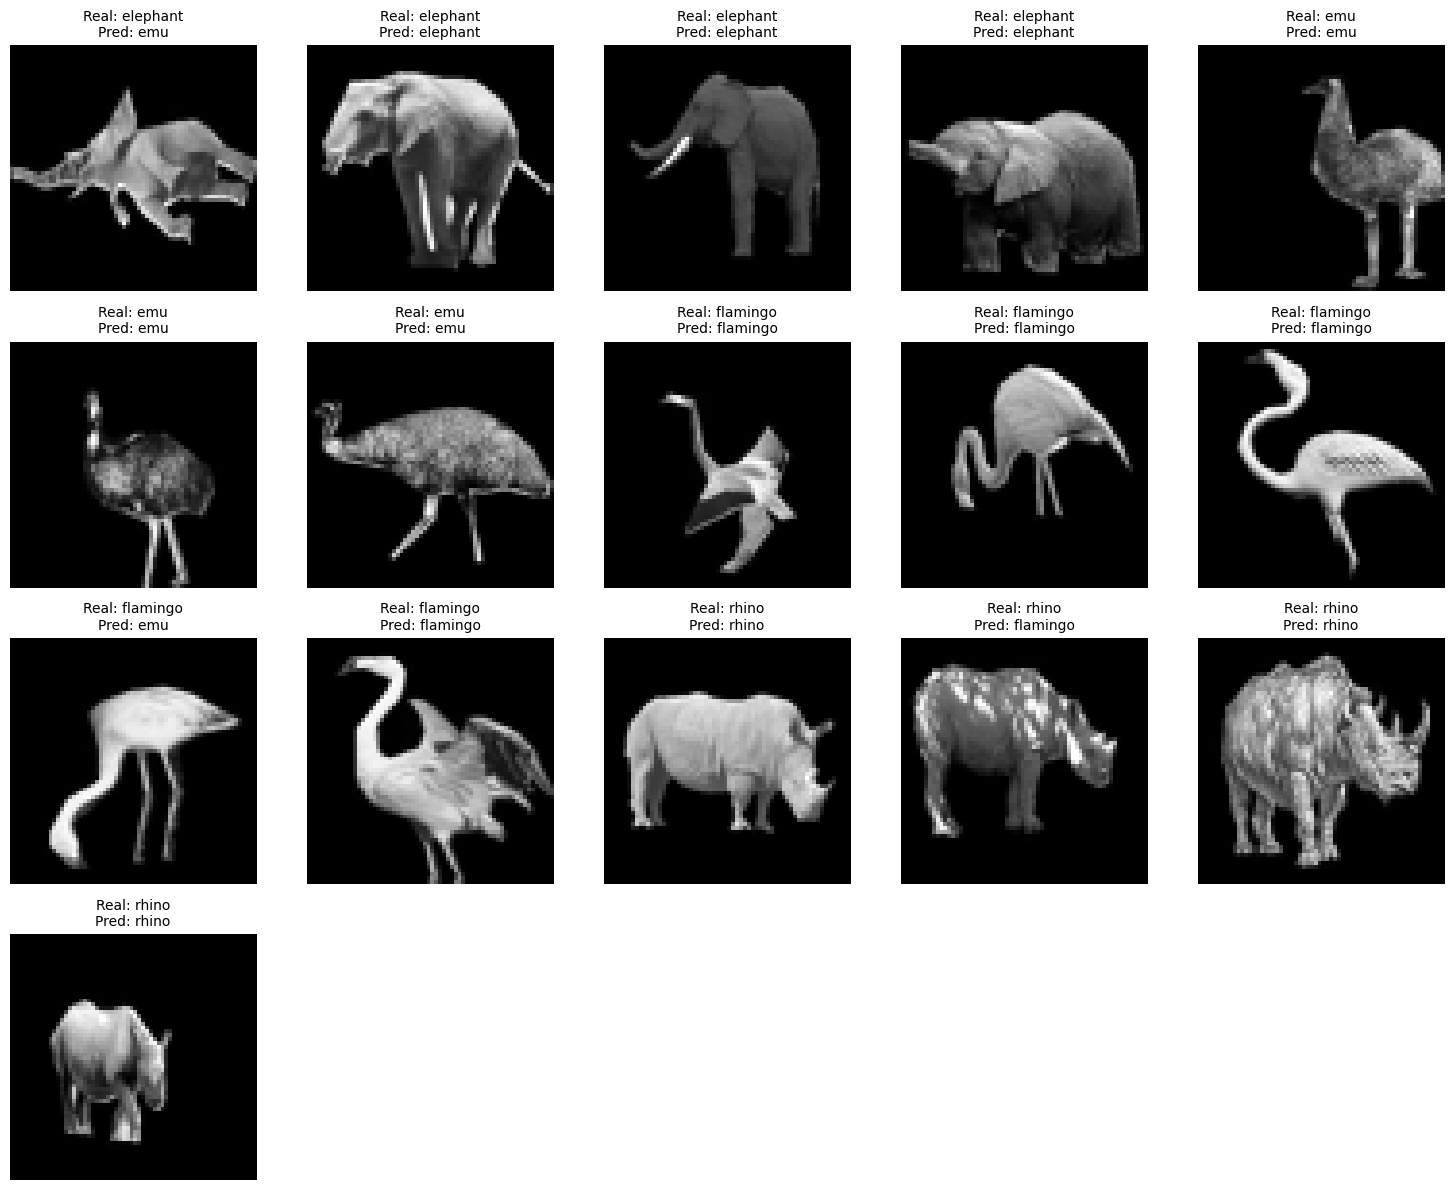

In [28]:
import matplotlib.pyplot as plt


#FUNCIÓN PARA TESTEAR, NO PONER EN ENTREGA FINAL.
def show_predictions(X_test, y_test, y_pred, image_size, num_examples=15):

    # Seleccionar los primeros num_examples o menos si hay menos datos
    num_examples = min(num_examples, len(X_test))
    
    # Crear una cuadrícula de subplots
    cols = 5
    rows = num_examples // cols + (num_examples % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    
    for i in range(num_examples):
        # Obtener la imagen original (desnormalizada si es necesario)
        img_array = X_test[i].reshape(image_size)
        
        # Etiquetas reales y predichas
        true_label = y_test[i]
        predicted_label = y_pred[i]
        
        # Determinar el eje correspondiente
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        
        # Mostrar la imagen en escala de grises
        ax.imshow(img_array, cmap="gray")
        ax.axis("off")
        
        # Título con etiqueta real y predicha
        ax.set_title(f"Real: {true_label}\nPred: {predicted_label}", fontsize=10)
    
    # Quitar ejes vacíos si hay menos imágenes que subplots
    for j in range(num_examples, rows * cols):
        fig.delaxes(axes[j // cols, j % cols] if rows > 1 else axes[j % cols])
    
    plt.tight_layout()
    plt.show()

# Usar la función para mostrar 50 predicciones
show_predictions(X_test, y_test, y_pred, image_size=image_size, num_examples=50)
